### 1. Import module and test

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import warnings 
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

In [2]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")

### 2. test Overview

* test Dictionary
    1. Survival : survival or not (0 : No, 1 : Yes)  
    2. pclass : Ticket class  
    3. sex : sex  
    4. Age : age in years  
    5. sibsp : # of sibilings / spouses aborad the titanic  
    6. parch : # of parents / children aborad the titanic  
    7. ticket : Ticket number  
    8. fare : Passenger fare  
    9. cabin : Cabin number  
    10. embarked : Port of Embarkation (C : Cherborug, Q : Queenstown, S : Southampton)  

**Train test**

각각 891개의 데이터가 있으며 12개의 column으로 이루어져 있음.

In [3]:
print(train.shape)

(891, 12)


Age에서 177개, Cabin에서 687개, Embarked에서 2개의 결측치가 있음.

In [4]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

각각의 데이터는 아래와 같이 이루어져 있음.

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


각 데이터의 분포는 아래와 같음.

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Test test**

Test test는 총 418개의 데이터로 이루어져있고 11개의 column으로 이루져있음

In [8]:
print(test.shape)

(418, 11)


Test 데이터는 Age에서 86개, Cabin에서 327개의 결측치가 있음.

In [9]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


In [10]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Test 데이터의 분포는 아래와 같음.

In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 3. Data Analyzation

Name column의 경우 Prefix를 정규표현식을 이용해 추출함.

In [12]:
train["Prefix"] = train["Name"].str.extract("([A-Za-z]+)\.")
test["Prefix"] = test["Name"].str.extract("([A-Za-z]+)\.")
train["Prefix"].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Sir           1
Countess      1
Mme           1
Ms            1
Lady          1
Capt          1
Don           1
Jonkheer      1
Name: Prefix, dtype: int64

In [13]:
test["Prefix"].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Prefix, dtype: int64

추출된 Prefix를 학습에 사용할 수 있도록 int화 시켜줍니다.

In [14]:
pre_dict = {"Mr":0, "Miss":1, "Mrs":2, "Master":3, "Dr":4, "Rev":4, "Major":4, "Col":4, "Mlle":4, "Ms":4, "Countess":4, "Jonkheer":4, "Lady":4, "Capt":4, "Don":4, "Sir":4, "Mme":4, "Dona":4}
train["Prefix"] = train["Prefix"].map(pre_dict)
test["Prefix"] = test["Prefix"].map(pre_dict)

In [15]:
train["Prefix"].value_counts()

0    517
1    182
2    125
3     40
4     27
Name: Prefix, dtype: int64

In [16]:
test["Prefix"].value_counts()

0    240
1     78
2     72
3     21
4      7
Name: Prefix, dtype: int64

Embarked column의 결측치를 채워넣음. Embarked의 경우, 절대적 다수인 "S"로 채워줍니다. Test의 경우에는 Embarked Column에 결측치가 없으므로 Train 데이터에만 작업을 진행합니다.

In [17]:
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)

<AxesSubplot:>

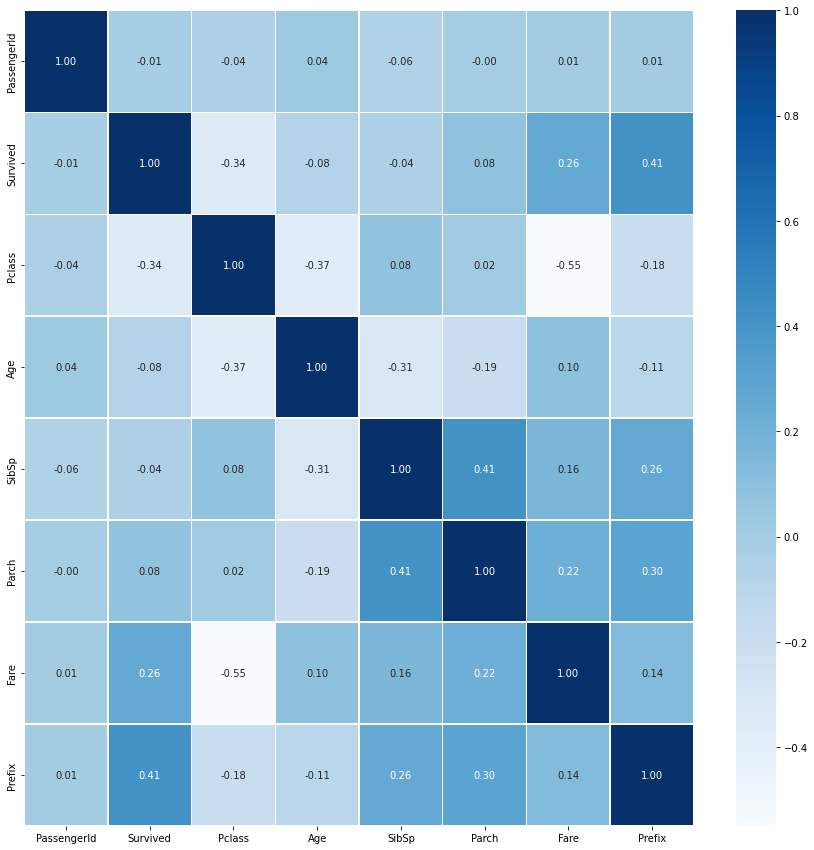

In [18]:
plt.figure(figsize=(15,15))
sb.heatmap(data=train.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

Age의 경우, Pclass와 Age의 Correlation이 가장 크므로, 각 Pclass의 평균치를 입력해줍니다.  
Test의 경우는 Train에서의 평균치를 삽입해줍니다.  
Test의 존재하는 Fare의 결측치 경우, Fare와 Pclass의 Correlation이 가장 크므로, Train의 각 Pclass의 평균치를 입력해줌.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

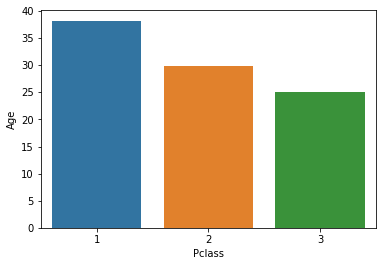

In [19]:
sb.barplot(x="Pclass", y="Age", ci=None, data= train)

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

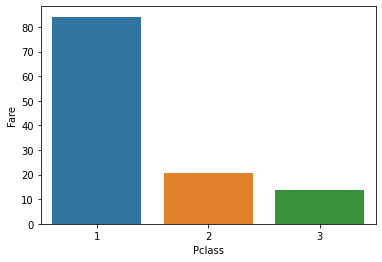

In [20]:
sb.barplot(x="Pclass", y="Fare", ci=None, data=train)

In [21]:
train["Age"].fillna(train.groupby("Pclass")["Age"].transform("mean"), inplace=True)

# for test
for idx in range(len(test)):
    if np.isnan(test["Age"][idx]):
        test["Age"][idx] = train[train["Pclass"] == test["Pclass"][idx]]["Age"].mean()
    if np.isnan(test["Fare"][idx]):
        test["Fare"][idx] = train[train["Pclass"] == test["Pclass"][idx]]["Fare"].mean()

현재 str 되어있는 Sex와 Embarked column또한 모델이 인식할 수 있도록 int화 시킴.

In [22]:
s_dict = {"male":0, "female":1}
train["Sex"] = train["Sex"].map(s_dict)
test["Sex"] = test["Sex"].map(s_dict)

In [23]:
ebk_dict = {"S": 0, "C": 1, "Q": 2}
train["Embarked"] = train["Embarked"].map(ebk_dict)
test["Embarked"] = test["Embarked"].map(ebk_dict)

In [24]:
sib_dict = {0:0, 1:1, 2:2, 3:2, 4:2, 5:2, 8:2}
train["SibSp"] = train["SibSp"].map(sib_dict)
test["SibSp"] = test["SibSp"].map(sib_dict)

In [25]:
parch_dict = {0:0, 1:1, 2:2, 3:2, 4:2, 5:2, 6:2, 9:2}
train["Parch"] = train["Parch"].map(parch_dict)
test["Parch"] = test["Parch"].map(parch_dict)

이후 필요없는 label의 경우 drop을 시켜줍니다.

In [26]:
train.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1, inplace=True)
test.drop(["Name", "Cabin", "Ticket"], axis=1, inplace=True)

각 데이터에 존재하는 Outlier를 확인합니다.

<AxesSubplot:xlabel='Age'>

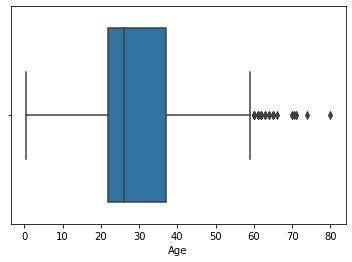

In [27]:
sb.boxplot(train["Age"])

<AxesSubplot:xlabel='Fare'>

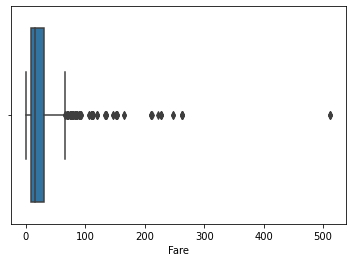

In [28]:
sb.boxplot(train["Fare"])

In [29]:
def change_outlier(data,col):
    q3 = train[col].quantile(q=0.75)
    q1 = train[col].quantile(q=0.25)
    iqr = 1.5 * (q3-q1)
    data.loc[data[col] < q1-iqr, col] = q1-iqr
    data.loc[data[col] > q3+iqr, col] = q3+iqr

In [30]:
change_outlier(train, "Age")
change_outlier(test, "Age")
change_outlier(train, "Fare")
change_outlier(test, "Fare")

In [31]:
train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Prefix
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.129575,0.400673,0.345679,24.046813,0.361392,0.740741
std,0.486592,0.836071,0.477990,12.765815,0.637727,0.663266,20.481625,0.635673,1.052077
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,0.000000,3.000000,0.000000,26.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,1.000000,3.000000,1.000000,37.000000,1.000000,0.000000,31.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,59.500000,2.000000,2.000000,65.634400,2.000000,4.000000


Age와 Fare는 범위가 넓기때문에 4개의 범위로 grouping을 진행합니다.

In [32]:
train.loc[train["Age"] <=22.0, "Age"] = 0
train.loc[(train["Age"] >22.0) & (train["Age"] <= 26.0), "Age"] = 1
train.loc[(train["Age"] >26.0) & (train["Age"] <= 37.0), "Age"] = 2
train.loc[train["Age"] > 37.0, "Age"] = 3

train.loc[train["Fare"] <= 7.91, "Fare"] = 0
train.loc[(train["Fare"] > 7.91) & (train["Fare"] <= 14.4542), "Fare"] = 1
train.loc[(train["Fare"] > 14.4542) & (train["Fare"] <= 31), "Fare"] = 2
train.loc[train["Fare"] > 31, "Fare"] = 3
train["Age"] = train["Age"].astype("int64")
train["Fare"] = train["Fare"].astype("int64")


test.loc[test["Age"] <= 22.0, "Age"] = 0
test.loc[(test["Age"] > 22.0) & (test["Age"] <= 26.0), "Age"] = 1
test.loc[(test["Age"] > 26.0) & (test["Age"] <= 37.0), "Age"] = 2
test.loc[test["Age"] > 37, "Age"] = 3

test.loc[test["Fare"] <= 7.91, "Fare"] = 0
test.loc[(test["Fare"] > 7.91) & (test["Fare"] <= 14.4542), "Fare"] = 1
test.loc[(test["Fare"] > 14.4542) & (test["Fare"] <= 31), "Fare"] = 2
test.loc[test["Fare"] > 31, "Fare"] = 3

test["Age"] = test["Age"].astype("int64")
test["Fare"] = test["Fare"].astype("int64")

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int64
 4   SibSp     891 non-null    int64
 5   Parch     891 non-null    int64
 6   Fare      891 non-null    int64
 7   Embarked  891 non-null    int64
 8   Prefix    891 non-null    int64
dtypes: int64(9)
memory usage: 62.8 KB


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Pclass       418 non-null    int64
 2   Sex          418 non-null    int64
 3   Age          418 non-null    int64
 4   SibSp        418 non-null    int64
 5   Parch        418 non-null    int64
 6   Fare         418 non-null    int64
 7   Embarked     418 non-null    int64
 8   Prefix       418 non-null    int64
dtypes: int64(9)
memory usage: 29.5 KB


데이터 전처리 후 Correlation 확인

<AxesSubplot:>

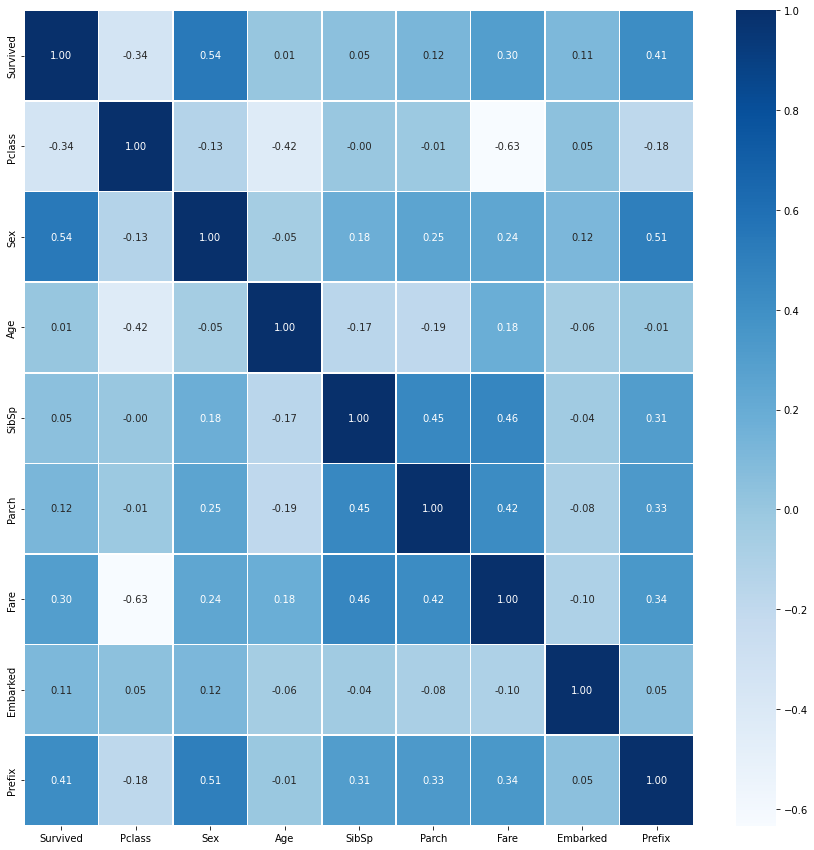

In [35]:
plt.figure(figsize=(15,15))
sb.heatmap(data=train.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

Correlation 0.1이상의 column을 제외한 데이터 drop

In [36]:
drop_list = ['SibSp', 'Age']
train.drop(drop_list, axis=1)
test.drop(drop_list, axis=1)

,PassengerId,Pclass,Sex,Parch,Fare,Embarked,Prefix
0,892,3,0,0,0,2,0
1,893,3,1,0,0,0,2
2,894,2,0,0,1,2,0
3,895,3,0,0,1,0,0
4,896,3,1,1,1,0,2
...,...,...,...,...,...,...,...
413,1305,3,0,0,1,0,0
414,1306,1,1,0,3,1,4
415,1307,3,0,0,0,0,0
416,1308,3,0,0,1,0,0


### 4. Train and Predict

In [37]:
# Classification module
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [38]:
y_train = train["Survived"]
x_train = train.drop(['Survived'], axis=1)

In [39]:
# Logistic Regression
logis = LogisticRegression()
logis.fit(x_train, y_train)
logis_score = logis.score(x_train, y_train)
print(f"Logistic regression Score: {logis_score}")

Logistic regression Score: 0.8204264870931538


In [40]:
# Support Vector Machine(SVM)
svm = SVC()
svm.fit(x_train, y_train)
svm_score = svm.score(x_train, y_train)
print(f"SVM score: {svm_score}")

SVM score: 0.8361391694725028


In [41]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
knn_score = knn.score(x_train, y_train)
print(f"KNN score: {knn_score}")

KNN score: 0.835016835016835


In [42]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
tree_score = tree.score(x_train, y_train)
print(f"Decision Tree Score: {tree_score}")

Decision Tree Score: 0.8956228956228957


In [43]:
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
forest_score = forest.score(x_train, y_train)
print(f"Random Forest score: {forest_score}")

Random Forest score: 0.8956228956228957


In [44]:
lda = LDA()
lda.fit(x_train, y_train)
lda_score = lda.score(x_train, y_train)
print(f"LDA score: {lda_score}")

LDA score: 0.7934904601571269


In [45]:
ridge = RidgeClassifier()
ridge.fit(x_train, y_train)
ridge_score = ridge.score(x_train, y_train)
print(f"Ridge score: {ridge_score}")

Ridge score: 0.7946127946127947


In [46]:
test_pred = test.copy()
test_pred = test_pred.drop("PassengerId", axis= 1)

In [47]:
y_pred = forest.predict(test_pred)
submission = pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived":y_pred})
submission.to_csv("submission.csv", index=False)

### 5. Train with K-Fold

In [48]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [49]:
# AutoML
from pycaret import classification

In [50]:
auto_ml = classification.setup(data=train, target="Survived", fold_strategy='stratifiedkfold')

,Description,Value
0,session_id,5055
1,Target,Survived
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(891, 9)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [51]:
auto_ml_result = classification.compare_models(fold=5, round=3, sort="Accuracy", n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.835,0.000,0.740,0.803,0.768,0.640,0.643,0.010
gbc,Gradient Boosting Classifier,0.835,0.859,0.697,0.832,0.758,0.634,0.640,0.066
lda,Linear Discriminant Analysis,0.833,0.869,0.740,0.799,0.767,0.637,0.640,0.036
lr,Logistic Regression,0.828,0.869,0.732,0.793,0.759,0.626,0.629,0.514
ada,Ada Boost Classifier,0.827,0.865,0.775,0.763,0.768,0.630,0.631,0.058
lightgbm,Light Gradient Boosting Machine,0.827,0.857,0.697,0.811,0.747,0.617,0.623,0.040
knn,K Neighbors Classifier,0.819,0.837,0.710,0.785,0.743,0.603,0.608,0.102
catboost,CatBoost Classifier,0.814,0.854,0.680,0.794,0.729,0.589,0.596,1.000
rf,Random Forest Classifier,0.809,0.843,0.693,0.771,0.728,0.582,0.585,0.452
et,Extra Trees Classifier,0.799,0.803,0.645,0.778,0.703,0.554,0.561,0.430


In [52]:
kfold = KFold(n_splits=20, shuffle=True, random_state=42)

In [53]:
print("---- Logistic Regression ----")
logis_k = LogisticRegression()
logis_k_score = cross_val_score(logis_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(logis_k_score)
print(f"Average logis_k score: {np.mean(logis_k_score)} \n")

print("---- Support Vector Machine ----")
svm_k = SVC()
svm_k_score = cross_val_score(svm_k, x_train, y_train, cv=kfold, n_jobs=1, scoring='accuracy')
print(svm_k_score)
print(f"Average svm_k score: {np.mean(svm_k_score)} \n")

print("---- K-Nerest Neighbor ----")
knn_k = KNeighborsClassifier(n_neighbors=5)
knn_k_score = cross_val_score(knn_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(knn_k_score)
print(f"Average knn_k score: {np.mean(knn_k_score)} \n")

print("---- Decision Tree ----")
tree_k = DecisionTreeClassifier()
tree_k_score = cross_val_score(tree_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(tree_k_score)
print(f"Average tree_k score: {np.mean(tree_k_score)} \n")

print("---- Random Forest ----")
forest_k = RandomForestClassifier()
forest_k_score = cross_val_score(forest_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(forest_k_score)
print(f"Average forest_k score: {np.mean(forest_k_score)} \n")

print("---- LDA ----")
lda_k = LDA()
lda_k_score = cross_val_score(lda_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(lda_k_score)
print(f"Average lda_k score: {np.mean(lda_k_score)} \n")

print("---- Ridge ----")
ridge_k = RidgeClassifier()
ridge_k_score = cross_val_score(ridge_k, x_train, y_train, cv=kfold, n_jobs=1, scoring="accuracy")
print(ridge_k_score)
print(f"Average ridge_k score: {np.mean(ridge_k_score)} \n")

---- Logistic Regression ----
[0.77777778 0.86666667 0.77777778 0.77777778 0.8        0.86666667
 0.77777778 0.73333333 0.82222222 0.91111111 0.86666667 0.86363636
 0.79545455 0.75       0.77272727 0.75       0.81818182 0.77272727
 0.90909091 0.90909091]
Average logis_k score: 0.8159343434343433 

---- Support Vector Machine ----
[0.8        0.86666667 0.8        0.77777778 0.82222222 0.86666667
 0.82222222 0.73333333 0.82222222 0.91111111 0.86666667 0.84090909
 0.77272727 0.75       0.79545455 0.81818182 0.81818182 0.77272727
 0.88636364 0.90909091]
Average svm_k score: 0.8226262626262626 

---- K-Nerest Neighbor ----
[0.84444444 0.86666667 0.8        0.82222222 0.84444444 0.8
 0.77777778 0.73333333 0.75555556 0.84444444 0.84444444 0.81818182
 0.75       0.68181818 0.79545455 0.81818182 0.86363636 0.63636364
 0.86363636 0.84090909]
Average knn_k score: 0.8000757575757576 

---- Decision Tree ----
[0.84444444 0.86666667 0.8        0.82222222 0.71111111 0.75555556
 0.82222222 0.77777778

In [54]:
lda_final = SVC()
lda_final.fit(x_train, y_train)
y_pred = lda_final.predict(test_pred)
submission = pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived":y_pred})
submission.to_csv("submission_kfold.csv", index=False)

### 5. Catboost

In [55]:
import optuna
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [56]:
def optimizerCAT(trial, data, target):
    param = {
        'random_state':42,
        'n_estimators': trial.suggest_int('n_estimators', 300, 3500),
        'depth': trial.suggest_int('depth', 6, 14),
        'fold_permutation_block': trial.suggest_int('fold_permutation_block', 1, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'od_pval': trial.suggest_float('od_pval', 0, 1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 4),
    }

    x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2)

    model = CatBoostClassifier(**param)
    model.fit(x_train, y_train, verbose= True)
    score = accuracy_score(model.predict(x_valid), y_valid)

    return score

In [57]:
study = optuna.create_study(direction="maximize", sampler=TPESampler())
x_train = train.drop(["Survived"], axis=1)
y_train = train["Survived"]
study.optimize(lambda trial: optimizerCAT(trial, x_train, y_train), n_trials=5)

print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-09-08 05:52:23,491] A new study created in memory with name: no-name-c246dee6-954a-474b-a25b-fb82bb59730f


0:	learn: 0.4303793	total: 50.6ms	remaining: 2m 3s
1:	learn: 0.3604040	total: 51.3ms	remaining: 1m 2s
2:	learn: 0.2826579	total: 53.1ms	remaining: 43.2s
3:	learn: 0.2405884	total: 54.2ms	remaining: 33.1s
4:	learn: 0.2353486	total: 54.9ms	remaining: 26.8s
5:	learn: 0.2344176	total: 55.5ms	remaining: 22.6s
6:	learn: 0.2342896	total: 55.9ms	remaining: 19.5s
7:	learn: 0.2342886	total: 56.3ms	remaining: 17.2s
8:	learn: 0.2341055	total: 56.6ms	remaining: 15.3s
9:	learn: 0.2335772	total: 56.9ms	remaining: 13.9s
10:	learn: 0.2254071	total: 57.7ms	remaining: 12.8s
11:	learn: 0.2219518	total: 58.3ms	remaining: 11.8s
12:	learn: 0.2195735	total: 59ms	remaining: 11s
13:	learn: 0.2180874	total: 59.8ms	remaining: 10.4s
14:	learn: 0.2170948	total: 60.4ms	remaining: 9.8s
15:	learn: 0.2161726	total: 61.1ms	remaining: 9.29s
16:	learn: 0.2155640	total: 61.7ms	remaining: 8.82s
17:	learn: 0.2150887	total: 62.4ms	remaining: 8.42s
18:	learn: 0.2147314	total: 63ms	remaining: 8.05s
19:	learn: 0.2143992	total: 6

[I 2022-09-08 05:52:26,605] Trial 0 finished with value: 0.7877094972067039 and parameters: {'n_estimators': 2447, 'depth': 10, 'fold_permutation_block': 41, 'learning_rate': 0.8278698017545524, 'od_pval': 0.49623225159419115, 'l2_leaf_reg': 0.8742136119900592}. Best is trial 0 with value: 0.7877094972067039.


0:	learn: 0.6722621	total: 509us	remaining: 356ms
1:	learn: 0.6522969	total: 1.62ms	remaining: 566ms
2:	learn: 0.6327434	total: 2.83ms	remaining: 658ms
3:	learn: 0.6105270	total: 3.51ms	remaining: 611ms
4:	learn: 0.5946342	total: 4.06ms	remaining: 564ms
5:	learn: 0.5737202	total: 5.09ms	remaining: 589ms
6:	learn: 0.5606083	total: 5.91ms	remaining: 585ms
7:	learn: 0.5460578	total: 6.64ms	remaining: 575ms
8:	learn: 0.5322676	total: 9.75ms	remaining: 748ms
9:	learn: 0.5199608	total: 10.9ms	remaining: 755ms
10:	learn: 0.5093734	total: 12.1ms	remaining: 756ms
11:	learn: 0.4980101	total: 13.1ms	remaining: 752ms
12:	learn: 0.4862553	total: 20.5ms	remaining: 1.08s
13:	learn: 0.4770876	total: 21.7ms	remaining: 1.06s
14:	learn: 0.4715828	total: 22.8ms	remaining: 1.04s
15:	learn: 0.4681883	total: 23.8ms	remaining: 1.02s
16:	learn: 0.4612125	total: 24.7ms	remaining: 994ms
17:	learn: 0.4530523	total: 25.2ms	remaining: 955ms
18:	learn: 0.4465228	total: 25.7ms	remaining: 923ms
19:	learn: 0.4416587	to

[I 2022-09-08 05:52:27,249] Trial 1 finished with value: 0.8156424581005587 and parameters: {'n_estimators': 700, 'depth': 6, 'fold_permutation_block': 248, 'learning_rate': 0.03973924299372533, 'od_pval': 0.6496846986609989, 'l2_leaf_reg': 1.7111750158119121}. Best is trial 1 with value: 0.8156424581005587.


685:	learn: 0.2262515	total: 480ms	remaining: 9.79ms
686:	learn: 0.2262278	total: 482ms	remaining: 9.12ms
687:	learn: 0.2262011	total: 483ms	remaining: 8.42ms
688:	learn: 0.2261706	total: 484ms	remaining: 7.72ms
689:	learn: 0.2261375	total: 486ms	remaining: 7.04ms
690:	learn: 0.2261180	total: 487ms	remaining: 6.34ms
691:	learn: 0.2260903	total: 487ms	remaining: 5.63ms
692:	learn: 0.2260579	total: 488ms	remaining: 4.93ms
693:	learn: 0.2260308	total: 489ms	remaining: 4.23ms
694:	learn: 0.2260150	total: 492ms	remaining: 3.54ms
695:	learn: 0.2259870	total: 495ms	remaining: 2.84ms
696:	learn: 0.2259533	total: 497ms	remaining: 2.14ms
697:	learn: 0.2259209	total: 498ms	remaining: 1.43ms
698:	learn: 0.2259037	total: 500ms	remaining: 714us
699:	learn: 0.2258745	total: 501ms	remaining: 0us
0:	learn: 0.4443084	total: 340us	remaining: 1.04s
1:	learn: 0.3342523	total: 1.86ms	remaining: 2.83s
2:	learn: 0.2694927	total: 3.77ms	remaining: 3.83s
3:	learn: 0.2430536	total: 5.25ms	remaining: 4s
4:	learn:

[I 2022-09-08 05:52:32,066] Trial 2 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 3050, 'depth': 11, 'fold_permutation_block': 67, 'learning_rate': 0.7886038300275137, 'od_pval': 0.7686387180072365, 'l2_leaf_reg': 1.1336535021101368}. Best is trial 2 with value: 0.8324022346368715.


0:	learn: 0.4817306	total: 461us	remaining: 651ms
1:	learn: 0.3892069	total: 1.98ms	remaining: 1.39s
2:	learn: 0.3575234	total: 2.84ms	remaining: 1.33s
3:	learn: 0.3313392	total: 3.53ms	remaining: 1.24s
4:	learn: 0.3156208	total: 4.42ms	remaining: 1.24s
5:	learn: 0.3130174	total: 6.42ms	remaining: 1.5s
6:	learn: 0.3112668	total: 8.01ms	remaining: 1.6s
7:	learn: 0.3016856	total: 9.32ms	remaining: 1.63s
8:	learn: 0.2850231	total: 10.6ms	remaining: 1.65s
9:	learn: 0.2739427	total: 11.2ms	remaining: 1.56s
10:	learn: 0.2628023	total: 12ms	remaining: 1.53s
11:	learn: 0.2539015	total: 13ms	remaining: 1.51s
12:	learn: 0.2517794	total: 13.6ms	remaining: 1.46s
13:	learn: 0.2465919	total: 14.7ms	remaining: 1.46s
14:	learn: 0.2465911	total: 15ms	remaining: 1.39s
15:	learn: 0.2430337	total: 15.7ms	remaining: 1.37s
16:	learn: 0.2389021	total: 16.9ms	remaining: 1.38s
17:	learn: 0.2367751	total: 17.9ms	remaining: 1.39s
18:	learn: 0.2365646	total: 18.5ms	remaining: 1.35s
19:	learn: 0.2342029	total: 19.

[I 2022-09-08 05:52:34,025] Trial 3 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 1410, 'depth': 10, 'fold_permutation_block': 208, 'learning_rate': 0.48017753257912726, 'od_pval': 0.5037700473521738, 'l2_leaf_reg': 1.1775303259297143}. Best is trial 2 with value: 0.8324022346368715.


1400:	learn: 0.2196208	total: 1.44s	remaining: 9.28ms
1401:	learn: 0.2196208	total: 1.44s	remaining: 8.24ms
1402:	learn: 0.2196206	total: 1.45s	remaining: 7.21ms
1403:	learn: 0.2196206	total: 1.45s	remaining: 6.18ms
1404:	learn: 0.2196204	total: 1.45s	remaining: 5.15ms
1405:	learn: 0.2196204	total: 1.45s	remaining: 4.12ms
1406:	learn: 0.2196204	total: 1.45s	remaining: 3.09ms
1407:	learn: 0.2196206	total: 1.45s	remaining: 2.06ms
1408:	learn: 0.2196191	total: 1.45s	remaining: 1.03ms
1409:	learn: 0.2196191	total: 1.45s	remaining: 0us
0:	learn: 0.4741814	total: 817us	remaining: 2.16s
1:	learn: 0.4010918	total: 1.54ms	remaining: 2.03s
2:	learn: 0.3379451	total: 2.63ms	remaining: 2.32s
3:	learn: 0.2825857	total: 4.76ms	remaining: 3.14s
4:	learn: 0.2754697	total: 5.61ms	remaining: 2.96s
5:	learn: 0.2749777	total: 6.03ms	remaining: 2.65s
6:	learn: 0.2736780	total: 7.04ms	remaining: 2.65s
7:	learn: 0.2638678	total: 8.11ms	remaining: 2.67s
8:	learn: 0.2593561	total: 9.24ms	remaining: 2.7s
9:	lea

[I 2022-09-08 05:52:42,953] Trial 4 finished with value: 0.7988826815642458 and parameters: {'n_estimators': 2641, 'depth': 13, 'fold_permutation_block': 236, 'learning_rate': 0.49928609534991913, 'od_pval': 0.22372192554954995, 'l2_leaf_reg': 0.965907738587751}. Best is trial 2 with value: 0.8324022346368715.


Best trial : score 0.8324022346368715, 
params {'n_estimators': 3050, 'depth': 11, 'fold_permutation_block': 67, 'learning_rate': 0.7886038300275137, 'od_pval': 0.7686387180072365, 'l2_leaf_reg': 1.1336535021101368}


In [58]:
cat_parameter = {'n_estimators': [3472], 'depth': [11], 'fold_permutation_block': [201], 'learning_rate': [0.7135660214466232], 'od_pval': [0.14156911916283843], 'l2_leaf_reg': [1.3590814127726265]}
cat = CatBoostClassifier(random_state=42, verbose=False)
model = RandomizedSearchCV(cat, cat_parameter, cv=kfold, n_jobs=1)
model.fit(x_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=20, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe2d543a940>,
                   iid='deprecated', n_iter=10, n_jobs=1,
                   param_distributions={'depth': [11],
                                        'fold_permutation_block': [201],
                                        'l2_leaf_reg': [1.3590814127726265],
                                        'learning_rate': [0.7135660214466232],
                                        'n_estimators': [3472],
                                        'od_pval': [0.14156911916283843]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [59]:
y_pred = model.predict(test_pred)
submission = pd.DataFrame({"PassengerId" : test["PassengerId"], "Survived":y_pred})
submission.to_csv("submission_catboost.csv", index=False)